# Impact of static imperfections on our X-band linac from 100 MeV to 500 GeV and beam-based alignment

In [1]:
import RF_Track as RFT
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Load the lattice from appropriate scripts

In [2]:
import scripts

## Let's define some key parameters
We use a structure to collect all relevant parameters

In [3]:
# Structure "setup"
class Setup:
    def __init__(self):
        self.Q = -1 # single-particle charge, in units of e
        self.mass = RFT.electronmass # MeV/c^2
        self.population = RFT.nC # 50 * RFT.pC; % number of real particles per bunch
        
        self.sigma_t = 0.100 # mm/c
        self.sigma_pt = 0.1 # permille, momentum spread

        self.P_i = 100 # initial momentum, MeV/c
        self.P_f = 500 # final momentum, MeV/c

        self.phid = -27 # deg, phase of the RF structures
        self.mu = 60 # deg, FODO phase advance per cell

## Let's build the linac lattice
We use a standard FODO lattice, with four structures every two consecutive quadrupoles and 90 degrees phase advance per cell

In [4]:
setup = Setup()
rf_name = 'data/TWS_Xband.dat'
LINAC = scripts.init_linac_lattice (rf_name, setup)

## Let's define and track the reference particle

In [5]:
P0 = scripts.init_reference_particle (setup)
# Track the reference particle
P1 = LINAC.track(P0)

In [6]:
P1.get_phase_space()

array([[   0.        ,    0.        ,    0.        ,    0.        ,
        9528.34799875,  518.04565692]])

In [7]:
LINAC.get_length()

9.528323996

In [8]:
print(P0.get_phase_space('%Vx %Vy %Vz'))
print(P1.get_phase_space('%Vx %Vy %Vz'))

[[0.         0.         0.99998694]]
[[0.         0.         0.99999951]]


## ...and a bunch

In [9]:
B0 = scripts.init_bunch(rf_name, setup)

## Let's study the impact of quadrupole misalignment

Assuming 100 $\mu$m and 100 $\mu$rad RMS pre-alignment error

In [10]:
sigma_X = 0.100 # mm
sigma_ROLL = 0.100 # mrad

We use the method: ```LINAC.scatter_elements``` which takes
* type of element
* X, Y, Z rms misalignment in mm
* ROLL, PITCH, YAW rms misalignemnt in mrad
* the reference point: 'entrance',  'center',  'exit'

Let's simulate a few random seeds...

Seed 1/10
Seed 2/10
Seed 3/10
Seed 4/10
Seed 5/10
Seed 6/10
Seed 7/10
Seed 8/10
Seed 9/10
Seed 10/10


Text(0, 0.5, '$\\epsilon_n$ [mm.mrad]')

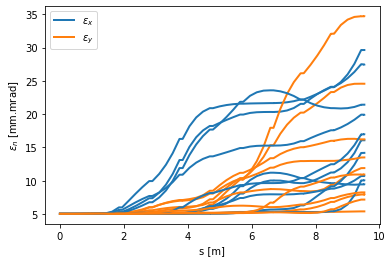

In [11]:
nSeeds = 10

for i in range(nSeeds):
    print('Seed {}/{}'.format(i+1, nSeeds))  
    LINAC.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center')
    B1 = LINAC.track(B0)
    T = LINAC.get_transport_table('%S %emitt_x %emitt_y')  
    plt.plot(T[:,0], T[:,1], 'C00', linewidth=2)
    plt.plot(T[:,0], T[:,2], 'C01', linewidth=2)
plt.legend([r'$\epsilon_x$', r'$\epsilon_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')

## Let's misalign the RF structures

Seed 1/10
Seed 2/10
Seed 3/10
Seed 4/10
Seed 5/10
Seed 6/10
Seed 7/10
Seed 8/10
Seed 9/10
Seed 10/10


Text(0, 0.5, '$\\epsilon_n$ [mm.mrad]')

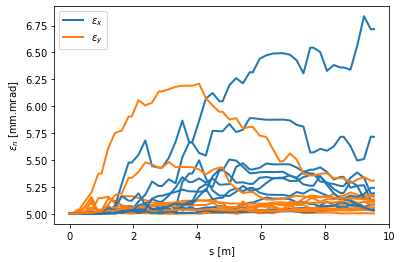

In [12]:
nSeeds = 10
LINAC.align_elements() # zeros the offsets of all the elements

for i in range(nSeeds):
    print('Seed {}/{}'.format(i+1, nSeeds))  
    LINAC.scatter_elements('rf_element', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center')
    B1 = LINAC.track(B0)
    T = LINAC.get_transport_table('%S %emitt_x %emitt_y')  
    plt.plot(T[:,0], T[:,1], 'C00', linewidth=2)
    plt.plot(T[:,0], T[:,2], 'C01', linewidth=2)
plt.legend([r'$\epsilon_x$', r'$\epsilon_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')

## Orbit Correction
We can correct the orbit computing the correctors strength required in order to center the bunch through all BPMs.

If $\mathbf{R}$ is the "response matrix" of our accelerator, that is, the matrix containing the response of each bpm to each corrector, 
\begin{equation*}
R_{ij} = \frac{\partial {b}_i}{\partial {\theta}_j},
\end{equation*}
then, one can anticipate -in linear approximation- the vector of BPM readings, $\mathbf{b}$, corresponding to any arbitrary set of corrector strengths, $ \boldsymbol{\theta}$:
\begin{equation*}
\mathbf{b} = \mathbf{R} \cdot \boldsymbol{\theta}.
\end{equation*}

Inverting this equation, given a measured orbit, $\mathbf{b}$, one can find the set of correcting correctors settings, $\Delta\boldsymbol{\theta}$:
\begin{equation*}
\Delta\boldsymbol{\theta}=-\mathbf{R}^{-1}\cdot \mathbf{b}\\
\end{equation*}
that provide a counteractin beam excitation. In this equation, $\left(\mathbf{R}\right)^{-1}$ denotes the pseudo-inverse of the matrix $\mathbf{R}$.

### First, we need to add correctors and bpms to our lattice

In [13]:
LINAC_BBA = scripts.init_linac_lattice(rf_name, setup)

In [14]:
R0 = LINAC_BBA.get_response_matrix(B0)

Text(0.5, 0.5, 'Bpms')

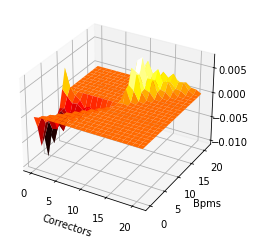

In [15]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
x, y = R0.shape
x, y = np.meshgrid(np.arange(x), np.arange(y))
ax.plot_surface(x, y, R0, cmap='hot')
ax.set_xlabel('Correctors')
ax.set_ylabel('Bpms')

In [16]:
R0[1:5,1:5]

array([[-0.00021411,  0.        ,  0.        ,  0.        ],
       [-0.00202649, -0.00015927,  0.        ,  0.        ],
       [-0.0022124 , -0.00158901, -0.0001341 ,  0.        ],
       [-0.00433916, -0.00410095, -0.00130767, -0.00010912]])

We use the method ```LINAC_BBA.orbit_correction(R0, B0, threshold)```
* The response matrix
* The incoming beam
* threshold is a cut applied to the singular values of the reponse matrix relative to the largest singular value

Seed 1/10
Seed 2/10
Seed 3/10
Seed 4/10
Seed 5/10
Seed 6/10
Seed 7/10
Seed 8/10
Seed 9/10
Seed 10/10


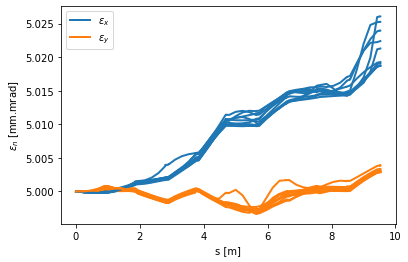

In [17]:
plt.figure()
nSeeds = 10
LINAC_BBA.align_elements() # zeros the offsets of all the elements
for i in range(nSeeds):
    print('Seed {}/{}'.format(i+1, nSeeds))
    LINAC_BBA.scatter_elements('quadrupole', sigma_X, sigma_X, 0, sigma_ROLL, 0, 0, 'center')
    LINAC_BBA.reset_correctors()
    LINAC_BBA.orbit_correction(R0, B0, 0.01); 
    LINAC_BBA.track(B0)
    T = LINAC_BBA.get_transport_table('%S %emitt_x %emitt_y')  
    plt.plot(T[:,0], T[:,1], 'C00', linewidth=2)
    plt.plot(T[:,0], T[:,2], 'C01', linewidth=2)
plt.legend([r'$\epsilon_x$', r'$\epsilon_y$'])
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')
plt.show()

The correction is extremely effective!

We can get the corrector strengths using the method ```LINAC_BBA.get_corrector_strengths()```, which returns T*mm

In [18]:
LINAC_BBA.get_correctors_strengths()

array([[ -9.13538843, -21.36813072],
       [-67.26297396,  19.61491272],
       [-13.24591726, -33.66533927],
       [ 60.1397548 ,  63.10466928],
       [ 39.33220131,  19.87721332],
       [ 20.55907604,  28.70691809],
       [ 76.93911598,  -6.11098176],
       [ 72.55374102,  -8.99255916],
       [119.44480846,  99.49743284],
       [ 41.07829598, 243.05374854],
       [  3.58226625,  23.85483854]])

## Dispersion-Free Steering
We change the RF phase to send a test beam with an energy different from the nominal. Dispersion-free steering aims to have nominal and test beams pass through the same BPM positions.

\begin{equation*}
\left(
\begin{array}{rl}
 & \mathbf{b}\\
\omega_d & \left(\mathbf{b}_1-\mathbf{b}\right)\\
% & \mathbf{0}
\end{array}
\right)=
\left(
\begin{array}{rl} & \mathbf{R_0}\\
\omega_d & \left(\mathbf{R_1} - \mathbf{R_0}\right)\\
%\omega_w & \mathbf{W}\\
%\beta & \mathbf{I}
\end{array}\right)\boldsymbol{\theta}.
\end{equation*}

Given a measured orbit and dispersive trajectory, the system of equations provides the correcting correctors' settings:
\begin{equation*}
\Delta\boldsymbol{\theta}=-\left(\begin{array}{rl}
 & \mathbf{R_{0}}\\
\omega_{d} & \left(\mathbf{R_{1}}-\mathbf{R_{0}}\right),
\end{array}\right)^{-1}\left(\begin{array}{rl}
 & \mathbf{b}\\
\omega_{d} & \left(\mathbf{b}_{1}-\mathbf{b}\right)
\end{array}\right),
\end{equation*}
where $\left(\,\cdots\,\right)^{-1}$ denotes the pseudo-inverse of the matrix.

In [19]:
def change_linac_phase(LINAC, phid):
    #for rf in LINAC.get_rf_elements():
    #    rf.set_phid(phid) 
    rf = LINAC.get_rf_elements()
    rf[0].set_phid(phid)

def get_h_dispersion(Lattice, B0, phid):
    Lattice.track(B0)
    x0 = Lattice.get_transport_table('%mean_x')   
    change_linac_phase(Lattice, 0)
    Lattice.track(B0)
    change_linac_phase(Lattice, phid)
    x1 = Lattice.get_transport_table('%mean_x')
    return np.squeeze(x1) - np.squeeze(x0)

In [20]:
change_linac_phase(LINAC_BBA, 0)
R1 = LINAC_BBA.get_response_matrix (B0)
change_linac_phase(LINAC_BBA, setup.phid)

Let's store the 4d emittance for the uncorrected machine, the orbit-corrected, and the dispersion-corrected (usually, one would look at emittance in X and Y separately; however, here for simplicity, we look at the emittance 4d).

In [21]:
sigma_X = 0.100 # mm
sigma_Xbpms = 0.020 # mm

nSeeds = 10
LINAC_BBA.align_elements() # zeros the offsets of all the elements

wgt = 10 # weighting factor between orbit and dispersion correction
R = np.concatenate((R0, wgt * (R1 - R0)))

S = np.squeeze(LINAC_BBA.get_transport_table('%S'))

T_Emt_U = np.zeros((nSeeds, len(S))) # uncorrected
T_Emt_O = np.zeros((nSeeds, len(S)))
T_Emt_D = np.zeros((nSeeds, len(S)))

T_D_U = np.zeros((nSeeds, len(S))) # uncorrected
T_D_O = np.zeros((nSeeds, len(S)))
T_D_D = np.zeros((nSeeds, len(S)))

for i in range(nSeeds):

    print('Seed {}/{}'.format(i+1, nSeeds)) 

    LINAC_BBA.scatter_elements('quadrupole', sigma_X, sigma_X, 0, 0, 0, 0, 'center')
    LINAC_BBA.scatter_elements('rf_element', sigma_X, sigma_X, 0, 0, 0, 0, 'center')
    LINAC_BBA.scatter_elements('bpm', sigma_Xbpms, sigma_Xbpms, 0, 0, 0, 0, 'center')
    LINAC_BBA.reset_correctors()

    print('Uncorrected machine...')
    LINAC_BBA.track(B0)   
    T_Emt_U[i] = np.squeeze(LINAC_BBA.get_transport_table('%emitt_4d'))
    T_D_U[i] = get_h_dispersion(LINAC_BBA, B0, setup.phid)
    
    # Orbit correction
    print('Orbit correction...')
    LINAC_BBA.orbit_correction(R0, B0, 0.01)   
    T_Emt_O[i] = np.squeeze(LINAC_BBA.get_transport_table('%emitt_4d'))
    T_D_O[i] = get_h_dispersion(LINAC_BBA, B0, setup.phid)
    
    # Dispersion correction
    print('Dispersion correction...\n')  
    Bpm0 = LINAC_BBA.get_bpm_readings()
    
    # Track the test beam
    change_linac_phase(LINAC_BBA, 0)
    LINAC_BBA.track(B0)
    change_linac_phase(LINAC_BBA, setup.phid)
    # Get the dispersive orbit
    Bpm1 = LINAC_BBA.get_bpm_readings()

    # Prepare for the correction computation
    Bpm0 = Bpm0.flatten('F') # transform into 1-column vector
    Bpm1 = Bpm1.flatten('F')

    # Compute correction
    B = np.concatenate((Bpm0, wgt * (Bpm1 - Bpm0)))
    C = -scipy.linalg.pinv(R, rtol=0.01) @ B

    # C is a vector containing 2*Ncorrectors items
    C = np.reshape(C, (2, int(len(C)/2))).T # We need to convert it in a 2-column matrix with Ncorrectors rows.
    # Apply the correction
    LINAC_BBA.vary_correctors_strengths(C)

    # Track the beam to get the emittance
    LINAC_BBA.track(B0)
    T_Emt_D[i] = np.squeeze(LINAC_BBA.get_transport_table('%emitt_4d'))
    T_D_D[i] = get_h_dispersion(LINAC_BBA, B0, setup.phid)

Seed 1/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 2/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 3/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 4/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 5/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 6/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 7/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 8/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 9/10
Uncorrected machine...
Orbit correction...
Dispersion correction...

Seed 10/10
Uncorrected machine...
Orbit correction...
Dispersion correction...



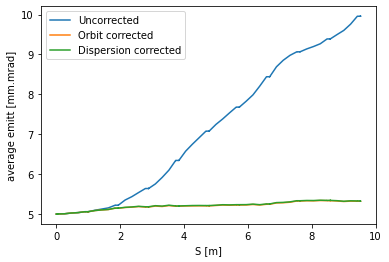

In [22]:
plt.figure()
S = np.squeeze(LINAC_BBA.get_transport_table('%S'))
plt.plot(S, np.mean(T_Emt_U, axis=0), label='Uncorrected')
plt.plot(S, np.mean(T_Emt_O, axis=0), label='Orbit corrected')
plt.plot(S, np.mean(T_Emt_D, axis=0), label='Dispersion corrected')
plt.xlabel('S [m]')
plt.ylabel('average emitt [mm.mrad]')
plt.legend()

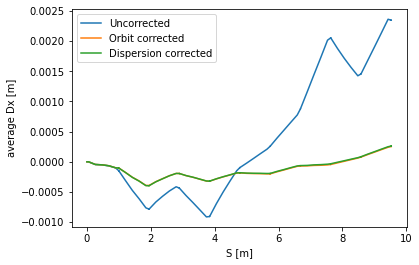

In [23]:
plt.figure()
plt.plot(S, np.mean(T_D_U, axis=0), label='Uncorrected')
plt.plot(S, np.mean(T_D_O, axis=0), label='Orbit corrected')
plt.plot(S, np.mean(T_D_D, axis=0), label= 'Dispersion corrected')
plt.xlabel('S [m]')
plt.ylabel('average Dx [m]')
plt.legend()

## Wakefield-Free Steering
We can apply the same principle to suppress the effect of wakefields on the trajectory. Wakefield-free steering uses a test beam with a different bunch charge to assess the impact of wakefields on the trajectory.

\begin{equation*}
\left(
\begin{array}{rl}
 & \mathbf{b}\\
\omega_d & \left(\mathbf{b}-\mathbf{b}_1\right)\\
\omega_w & \left(\mathbf{b}-\mathbf{b}_w\right)\\
% & \mathbf{0}
\end{array}
\right)=
\left(
\begin{array}{rl} & \mathbf{R_0}\\
\omega_d & \left(\mathbf{R_1} - \mathbf{R_0}\right)\\
\omega_w & \left(\mathbf{R}_w - \mathbf{R_0}\right)\\
%\omega_w & \mathbf{W}\\
%\beta & \mathbf{I}
\end{array}\right)\cdot\boldsymbol{\theta}.
\end{equation*}
Effectively, the trajectory proposed by this algorithm will be minimally subject to the impact of wakefields, that is, the trajectory passing close to each structure's electromagnetic axis. More information about Wakefield-free steering can be found at this reference [1].

[[1]](https://accelconf.web.cern.ch/IPAC2014/doi/JACoW-IPAC2014-TUPRO065.html) A. Latina et al., "Tests of Beam-based Alignment at FACET", IPAC'14, Dresden, 2014.

So, let's create a bunch with a reduced charge

In [24]:
# setup_wfs
setup_wfs = Setup()
setup_wfs.Q = -1 # single-particle charge, in units of e
setup_wfs.mass = RFT.electronmass # MeV/c^2
setup_wfs.population = 0.8 * RFT.nC # it was 1 nC for the nominal bunch

B0_wfs = scripts.init_bunch(rf_name, setup_wfs)

### Wakefield response matrix

In [25]:
LINAC_BBA.align_elements() # zeros the offsets of all the elements

In [26]:
R1_wfs = LINAC_BBA.get_response_matrix (B0_wfs)

In [27]:
sigma_X = 0.050 # mm
sigma_Xbpms = 0.020 # mm

nSeeds = 10

LINAC_BBA.align_elements() # zeros the offsets of all the elements

wgt1 = 10 # weighting factor between orbit and dispersion correction
wgt2 = 10 # weighting factor between orbit and wakefield correction

R = np.vstack((R0, wgt1 * (R1 - R0), wgt2 * (R1_wfs - R0)))

S = np.squeeze(LINAC_BBA.get_transport_table('%S'))
T_Emt_U = np.zeros((nSeeds, len(S))) # uncorrected
T_Emt_O = np.zeros((nSeeds, len(S)))
T_Emt_W = np.zeros((nSeeds, len(S)))

for i in range(nSeeds):

    print('Seed {}/{}'.format(i+1, nSeeds)) 

    LINAC_BBA.scatter_elements('quadrupole', sigma_X, sigma_X, 0, 0, 0, 0, 'center')
    LINAC_BBA.scatter_elements('rf_element', sigma_X, sigma_X, 0, 0, 0, 0, 'center')
    LINAC_BBA.scatter_elements('bpm', sigma_Xbpms, sigma_Xbpms, 0, 0, 0, 0, 'center')
    LINAC_BBA.reset_correctors();

    print('Uncorrected machine...')
    LINAC_BBA.track(B0)   
    T_Emt_U[i] = np.squeeze(LINAC_BBA.get_transport_table('%emitt_4d'))
    
    # Orbit correction
    print('Orbit correction...')
    LINAC_BBA.orbit_correction(R0, B0, 0.01)   
    T_Emt_O[i] = np.squeeze(LINAC_BBA.get_transport_table('%emitt_4d'))
    
    # Dispersion and Wakefield correction
    print('Dispersion and Wakefield correction...')
    
    Bpm0 = LINAC_BBA.get_bpm_readings()

    # Track the test beam
    change_linac_phase (LINAC_BBA, 0)
    LINAC_BBA.track(B0);
    change_linac_phase(LINAC_BBA, setup.phid)

    # Get the dispersive orbit
    Bpm1 = LINAC_BBA.get_bpm_readings()

    # Prepare for the correction computation
    Bpm0 = Bpm0.flatten('F') # transform into 1-column vector
    Bpm1 = Bpm1.flatten('F')

    # Track the test beam
    LINAC_BBA.track(B0_wfs);
    
    # Get the wakefield orbit
    Bpm1_wfs = LINAC_BBA.get_bpm_readings()

    # Make it a 1-column vector
    Bpm1_wfs = Bpm1_wfs.flatten('F')

    # Compute correction
    B = np.concatenate((Bpm0, wgt1 * (Bpm1 - Bpm0), wgt2 * (Bpm1_wfs - Bpm0)))
    C = -scipy.linalg.pinv(R, rtol=0.01) @ B

    # C is a vector containing 2*Ncorrectors items
    C = np.reshape(C, (2, int(len(C)/2))).T # We need to convert it in a 2-column matrix with Ncorrectors rows.

    # Apply the correction
    LINAC_BBA.vary_correctors_strengths(C)

    # Track the beam to get the emittance
    LINAC_BBA.track(B0)
    T_Emt_W[i] = np.squeeze(LINAC_BBA.get_transport_table('%emitt_4d'))


Seed 1/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 2/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 3/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 4/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 5/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 6/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 7/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 8/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 9/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...
Seed 10/10
Uncorrected machine...
Orbit correction...
Dispersion and Wakefield correction...


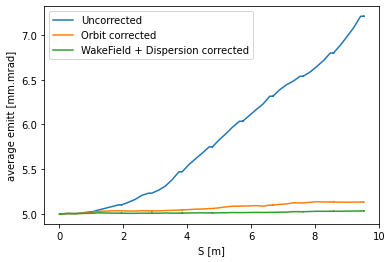

In [28]:
plt.figure()
S = np.squeeze(LINAC_BBA.get_transport_table('%S'))
plt.plot(S, np.mean(T_Emt_U, axis=0), label='Uncorrected')
plt.plot(S, np.mean(T_Emt_O, axis=0), label='Orbit corrected')
plt.plot(S, np.mean(T_Emt_W, axis=0), label= 'WakeField + Dispersion corrected')
plt.xlabel('S [m]')
plt.ylabel('average emitt [mm.mrad]')
plt.legend()